# Import Problem Instance
We start by importing a simple problem instance to demonstrate the tsplib reader.


In [1]:
from tsplib95 import tsplib95
import itertools
import networkx as nx

instance = tsplib95.load_problem('./tsplib/ulysses16.tsp')

instance.comment

'Odyssey of Ulysses (Groetschel/Padberg)'

Remember, this repository contains a small selection of TSP instances that you can use to test your algorithms.

| name | nodes | description |
|------|-------|-------------|
| ulysses16.tsp | 16 | Odyssey of Ulysses |
| ulysses7.tsp | 7 | subset of ulysses16 for testing purposes |
| bayg29.tsp | 29 | 29 Cities in Bavaria |
| bier127.tsp | 127 | 127 Biergaerten in Augsburg |
| bier20.tsp | 20 | subset of bier127 |
| brazil58.tsp | 58 | 58 cities in Brazil |
| ali535.tsp | 535 | 535 Airports around the globe |
| d18512.tsp | 18512 | 18512 places in Germany |

The following calls show the dimension = number of nodes of the problem, its node set and the edge weights. The functions `instance.get_nodes()` and `instance.get_edges()` are implemented as iterators, so you can loop over the nodes or edges. To get a list of nodes or edges, you have to explicitly construct one using `list(instance.get_nodes())`. Note that node counting may start at 1 for some instances while others use 0 as starting point. For convenience, we store the index of the first node as `first_node`.


In [2]:
instance.dimension

instance.get_nodes()
print("List of nodes: ", list(instance.get_nodes()))

first_node = min(instance.get_nodes())
first_node

for i,j in instance.get_edges():
    if i >= j:
        continue
    print(f"edge {{ {i:2},{j:2} }} has weight {instance.wfunc(i,j):3}.")


List of nodes:  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
edge {  1, 2 } has weight   6.
edge {  1, 3 } has weight   5.
edge {  1, 4 } has weight   3.
edge {  1, 5 } has weight  11.
edge {  1, 6 } has weight   8.
edge {  1, 7 } has weight   7.
edge {  1, 8 } has weight   1.
edge {  1, 9 } has weight  12.
edge {  1,10 } has weight   8.
edge {  1,11 } has weight  26.
edge {  1,12 } has weight   5.
edge {  1,13 } has weight   5.
edge {  1,14 } has weight   5.
edge {  1,15 } has weight   7.
edge {  1,16 } has weight   1.
edge {  2, 3 } has weight   1.
edge {  2, 4 } has weight   4.
edge {  2, 5 } has weight  17.
edge {  2, 6 } has weight  14.
edge {  2, 7 } has weight  13.
edge {  2, 8 } has weight   6.
edge {  2, 9 } has weight  17.
edge {  2,10 } has weight  13.
edge {  2,11 } has weight  32.
edge {  2,12 } has weight  11.
edge {  2,13 } has weight  11.
edge {  2,14 } has weight  11.
edge {  2,15 } has weight  13.
edge {  2,16 } has weight   7.
edge {  3, 4 } has weight   5

You have already seen how to draw a graph, here is the relevant code again.

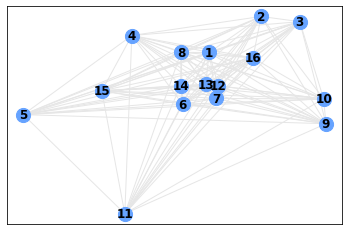

In [5]:
G = instance.get_graph()
if instance.is_depictable():
    pos = {i: instance.get_display(i) for i in instance.get_nodes()}
else:
    pos = nx.drawing.layout.spring_layout(G)
nx.draw_networkx_nodes(G, pos, node_color='#66a3ff', node_size=200)
nx.draw_networkx_labels(G, pos, font_weight='bold' )
nx.draw_networkx_edges(G, pos,  edge_color='#e6e6e6')

# Implementing the standard model with subtour elimination in Gurobi
We will implement the standard model with subtour elimination callback using binary variables $x_{ij} \in \{0,1\}$ to indicate whether edge $\{i,j\}$ is being used in the tour. To avoid double counting edges, we employ the convention that $i < j$ for an edge $\{i,j\}$ and we will denote the resulting edge set by $E$. The formulation looks like this:

\begin{align}
\min\;&\sum_{\{i,j\} \in E} c_{i,j} \cdot x_{i,j}\\
&\sum_{j: \{i,j\} \in E} x_{i,j} = 2 \quad \text{for all nodes $i$}\\
&\sum_{\{i,j\} \in \delta(S)} x_{ij} \ge 2 \quad \text{for all $S \subsetneq V$, $S \ne \emptyset$}\\
&x_{i,j} \in \{0,1\}
\end{align}

## Creating the variables
We start by creating the model and the variables. Notice that we already define the objective function by using the `obj` parameter upon variable creation.

In [7]:
import gurobipy as grb

model = grb.Model(name="Subtour TSP formulation")

x = grb.tupledict()
for i,j in instance.get_edges():
    if i < j:
        x[i,j] = model.addVar(obj=instance.wfunc(i,j), vtype=grb.GRB.BINARY, name=f"x[{i},{j}]")

Academic license - for non-commercial use only


## Adding the degree constraints
Next, we add the constraints for our model with the exception of the subtour elimination constraints. We use the sum method of our variables to express the summation in an elegant way.

In [8]:
for i in instance.get_nodes():
    model.addConstr(x.sum(i,'*') + x.sum('*',i) == 2, name=f"degree_ctr[{i}]")

## Starting the Optimization Process
Finally, we set the objective to minimization and call the optimizer.

In [9]:
model.ModelSense = grb.GRB.MINIMIZE
model.reset()
model.optimize()

Optimize a model with 16 rows, 120 columns and 240 nonzeros
Variable types: 0 continuous, 120 integer (120 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 3e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e+00, 2e+00]
Found heuristic solution: objective 148.0000000
Presolve time: 0.00s
Presolved: 16 rows, 120 columns, 240 nonzeros
Variable types: 0 continuous, 120 integer (120 binary)

Root relaxation: objective 6.200000e+01, 20 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0      62.0000000   62.00000  0.00%     -    0s

Explored 0 nodes (20 simplex iterations) in 0.01 seconds
Thread count was 8 (of 8 available processors)

Solution count 2: 62 148 

Optimal solution found (tolerance 1.00e-04)
Best objective 6.200000000000e+01, best bound 6.200000000000e+01, gap 0.0000%


## Querying and Visualizing the Solution
Before we visualize our result, let us look at a few key figures of our solution.

In [ ]:
model.ObjVal

In [10]:
solution_edges = [(i,j) for i,j in x.keys() if x[i,j].x > 0.9]
solution_edges

[(1, 8),
 (1, 16),
 (2, 3),
 (2, 4),
 (3, 4),
 (5, 11),
 (5, 15),
 (6, 7),
 (6, 15),
 (7, 10),
 (8, 16),
 (9, 10),
 (9, 11),
 (12, 13),
 (12, 14),
 (13, 14)]

For debugging purposes, it might be helpful to export the model held by Gurobi into a human-readable format:

In [11]:
model.write('test.lp')

 Finally, let us visualize the solution using NetworkX. In this case, we need to prescribe positions and draw the nodes and two layers of edges separately.

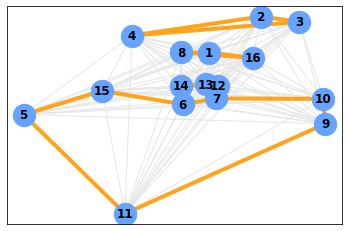

In [12]:
if instance.is_depictable():
    pos = {i: instance.get_display(i) for i in instance.get_nodes()}
else:
    pos = nx.drawing.layout.spring_layout(G)
nx.draw_networkx_nodes(G, pos, node_color='#66a3ff', node_size=500)
nx.draw_networkx_labels(G, pos, font_weight='bold' )
nx.draw_networkx_edges(G, pos,  edge_color='#e6e6e6')
nx.draw_networkx_edges(G, pos,  edgelist=solution_edges, edge_color='#ffa31a', width=4)

## Subtour elimination
As you can hopefully see (depending on the instance you selected), the solution may contain a subtour. Let us add a callback to detect and eliminate subtours in an integer solution. 

We start by defining a function that, given a list of edges, finds a subtour if there is one. For a more concise implementation, we use a function of networkx to find such a subtour: We construct an auxiliary graph $G_{\text{aux}}$, find a cycle in this graph and return just the nodes contained in this cycle.

In [16]:
def find_subtour_set(nodes, edges):
    G_aux = nx.Graph()
    G_aux.add_nodes_from(nodes)
    G_aux.add_edges_from(edges)
    return set(itertools.chain(*nx.find_cycle(G_aux)))

find_subtour_set(instance.get_nodes(), [(i,j) for i,j in x.keys() if x[i,j].x > 0.9])

{1, 8, 16}

### Define a callback
Next, we need to define a callback function that adds a violated subtour inequality if one exists. In Gurobi, there is just one "global" callback function that two parameters: The `model` and a constant called `where` (a "Callback Code") that indicates at which position in the optimization process the callback has been invoked. The documentation contains a list of the available codes at http://www.gurobi.com/documentation/8.0/refman/callback_codes.html#sec:CallbackCodes. We want our callback to spring into action whenever a new integer solution has been found, so the relevant callback code is `GRB.Callback.MIPSOL`.

Notice that we can only access parameters and current values of our model through the model object, not through the variables we have defined above. The model supplies a number of `cbGet...` methods for this purpose. To access our variables, we need to define a _user variable_ in the model that stores this information and makes it accessible in the callback. User variables can be any member of the model objects that starts with an underscore. We will add a parameter `_vars` to our model that simply stores the x variables and then use this parameter in the callback to access the current solution.

To add a new constraint, we use the method `cbLazy` of our model that adds a new lazy constraint. The node will then be re-evaluated automatically.

### Subtour Elimination Callback
 **Task 1:** In the following function, complete the definition of the `cut_edges` list to make the subtour elimination work properly.

In [17]:
def subtour_callback(model, where):
    if where == grb.GRB.Callback.MIPSOL:
        sol = model.cbGetSolution(model._vars)
        S = find_subtour_set(model._instance.get_nodes(), [(i,j) for i,j in model._vars.keys() if sol[i,j] > 0.9])
        if len(S) < model._instance.dimension:
            # TODO: cut_edges
            cut_edges = [(i,j) for i,j in model._vars.keys() if ((i in S and j not in S) or (i not in S and j in S))]
            model.cbLazy(sum(model._vars[i,j] for i,j in cut_edges) >= 2)

### Add Callback to the Model 
Let us now add the variables to the model and resolve, this time using the callback. Also, we need to switch on lazy constraints by setting the appropropriate parameter. The callback function is simply passed as a parameter to the optimizer.

In [23]:
model._vars = x # for use in the callback
model._instance = instance # for use in the callback
model.reset()
model.Params.lazyConstraints = 1 # use lazy constraints
model.optimize(subtour_callback) # use callback to add lazy constraints

Parameter lazyConstraints unchanged
   Value: 1  Min: 0  Max: 1  Default: 0
Optimize a model with 16 rows, 120 columns and 240 nonzeros
Variable types: 0 continuous, 120 integer (120 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 3e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e+00, 2e+00]
Presolve time: 0.00s
Presolved: 16 rows, 120 columns, 240 nonzeros
Variable types: 0 continuous, 120 integer (120 binary)

Root relaxation: objective 6.800000e+01, 25 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   68.00000    0    6          -   68.00000      -     -    0s
     0     0   70.50000    0   10          -   70.50000      -     -    0s
H    0     0                      72.0000000   70.50000  2.08%     -    0s
H    0     0                      71.0000000   70.50000  0.70%     -    0s

Cutt

### Results
Let's have a look at the results.

In [20]:
model.ObjVal

71.0

In [21]:
solution_edges = [(i,j) for i,j in x.keys() if x[i,j].x > 0.9]
solution_edges

[(1, 3),
 (1, 16),
 (2, 3),
 (2, 4),
 (4, 8),
 (5, 6),
 (5, 11),
 (6, 7),
 (7, 14),
 (8, 15),
 (9, 10),
 (9, 11),
 (10, 12),
 (12, 13),
 (13, 16),
 (14, 15)]

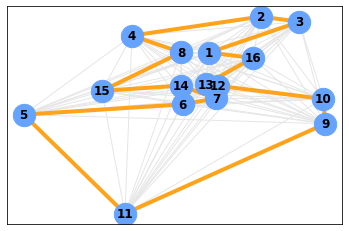

In [22]:
if instance.is_depictable():
    pos = {i: instance.get_display(i) for i in instance.get_nodes()}
else:
    pos = nx.drawing.layout.spring_layout(G)
nx.draw_networkx_nodes(G, pos, node_color='#66a3ff', node_size=500)
nx.draw_networkx_labels(G, pos, font_weight='bold' )
nx.draw_networkx_edges(G, pos,  edge_color='#e6e6e6')
nx.draw_networkx_edges(G, pos,  edgelist=solution_edges, edge_color='#ffa31a', width=4)

## Fractional Subtour Elimination
Finally, let us try to implement a separation procedure for subtour elimination constraints that works on the relaxation and does not need an integer solution. This can be done by solving a minimum cut problem on an auxiliary graph where we fix an arbitrary source node (we will use node $1$) and iterate through all possible target nodes until we find a minimum cut that has a value of less than $2$. For this cut, the corresponding subtour elimination constraint is inserted as a lazy cut. We modify our callback to use the callback code `MIPNODE` instead of `MIPSOL` and query `GRB.Callback.MIPNODE_STATUS` to see whether the node has already been solved to (fractional) optimality. For computing the minimum cut we again use an algorithm provided by the `networkx` package.
Note that we have substituted `cbGetSolution` by `cbGetNodeRel`, as a solution is not generally available at any node. Also, we have to include the `MIPSOL` callback branch, because `MIPNODE` might not be called for nodes that yield an integer optimum right away.


### Define Separation Method

In [29]:
import itertools
def find_minimum_cut_partition(instance, sol):
    G_flow = instance.get_graph()
    for i,j in G_flow.edges():
            if (i,j) in sol:
                G_flow[i][j]['capacity'] = sol[i,j]
            else:
                G_flow[i][j]['capacity'] = 0
    for t in G_flow.nodes() - {1}:
        cut_value, S = nx.minimum_cut(G_flow, 1, t, capacity='capacity')
        if cut_value < 2:
            return S[0]
    return set() #no cut with value < 2 has been found

### Subtour Elimination Callback
**Task 2:** In the following callback, fill in the code for adding the correct subtour elimination inequalities.

In [30]:
def subtour_elimination_callback(model, where):
    if where == grb.GRB.Callback.MIPSOL:
        sol = model.cbGetSolution(model._vars)
        S = find_subtour_set(model._instance.get_nodes(), [(i,j) for i,j in model._vars.keys() if sol[i,j] > 0.9])
        if len(S) < model._instance.dimension:
            cut_edges = [(i,j) for i,j in model._vars.keys() if ((i in S and j not in S) or (i not in S and j in S))]
            model.cbLazy(sum(model._vars[i,j] for i,j in cut_edges) >= 2)
    elif where == grb.GRB.Callback.MIPNODE and model.cbGet(grb.GRB.Callback.MIPNODE_STATUS) == grb.GRB.Status.OPTIMAL:
        sol = model.cbGetNodeRel(model._vars)
        S = find_minimum_cut_partition(model._instance, sol)
        if 0 < len(S) < model._instance.dimension:
            cut_edges = [(i,j) for i,j in model._vars.keys() if ((i in S and j not in S) or (i not in S and j in S))]
            model.cbLazy(sum(model._vars[i,j] for i,j in cut_edges) >= 2)

### Optimize

In [31]:
model._vars = x
model._instance = instance
model.reset()
model.Params.lazyConstraints = 1
model.optimize(subtour_elimination_callback)

Parameter lazyConstraints unchanged
   Value: 1  Min: 0  Max: 1  Default: 0
Optimize a model with 16 rows, 120 columns and 240 nonzeros
Variable types: 0 continuous, 120 integer (120 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 3e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e+00, 2e+00]
Presolve time: 0.00s
Presolved: 16 rows, 120 columns, 240 nonzeros
Variable types: 0 continuous, 120 integer (120 binary)

Root relaxation: objective 6.800000e+01, 25 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   68.00000    0    6          -   68.00000      -     -    0s
     0     0   70.50000    0   10          -   70.50000      -     -    0s
H    0     0                      72.0000000   70.50000  2.08%     -    0s
H    0     0                      71.0000000   70.50000  0.70%     -    0s

Cutt

### Results

In [32]:
model.ObjVal

71.0

In [33]:
solution_edges = [(i,j) for i,j in x.keys() if x[i,j].x > 0.9]
solution_edges

[(1, 3),
 (1, 16),
 (2, 3),
 (2, 4),
 (4, 8),
 (5, 6),
 (5, 11),
 (6, 7),
 (7, 14),
 (8, 15),
 (9, 10),
 (9, 11),
 (10, 12),
 (12, 13),
 (13, 16),
 (14, 15)]

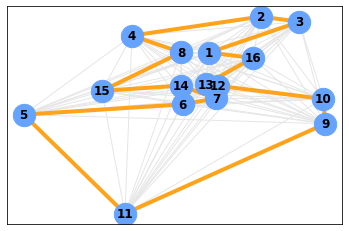

In [34]:
if instance.is_depictable():
    pos = {i: instance.get_display(i) for i in instance.get_nodes()}
else:
    pos = nx.drawing.layout.spring_layout(G)
nx.draw_networkx_nodes(G, pos, node_color='#66a3ff', node_size=500)
nx.draw_networkx_labels(G, pos, font_weight='bold' )
nx.draw_networkx_edges(G, pos,  edge_color='#e6e6e6')
nx.draw_networkx_edges(G, pos,  edgelist=solution_edges, edge_color='#ffa31a', width=4)

### Comparison
**Task 3:** Compare the two different callbacks with respect to running time and number of cuts added. Try different TSPLIB instances. Compare this formulation to MTZ.
